In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from IPython.display import Markdown as md

import generate_horndeski as gen

import cosmology as co
import cosmoGW as cosmo
import horndeski as ho
import plot_sets
import GW_analytical as an
import interferometry as inter

print(gen.__doc__)


generate_horndeski.py is a Python routine  that can be used to generate
the plots and compute the postprocessing results of Y. He, A. Roper Pol,
A. Brandenburg, "Modified propagation of gravitational waves from the early
radiation era," submitted to JCAP (2022).

It reads the pickle run variables that can be generated by the routine
initialize_horndeski.py.

The function run() executes the code.

Author: Alberto Roper Pol
created: 01/12/2022



In [2]:
#### Once that the runs have been read from the files and pickle variables have been generated,
#### one can load the pickle variables with the corresponding runs for efficiency

### The runs are needed to be run if the pickle variables for the time series and spectra
### have not been generated, otherwise it is not needed

### In order to execute this part of the code, one needs to first download the numerical data
### files from Zenodo (https://zenodo.org/record/7408601#.Y5c6G-zMJp8) and store them under
### the same directory as this notebook. Then, one needs to run the initialize_horndeski.ipynb
### notebook and finally set rd to False here to directly use the numerical results.

rd = False
if rd:
    runs_M0 = 0
    runs_M0_lowk = 0
    runs_M1 = 0
    runs_M2 = 0
    runs_M3 = 0
    runs_M3_lowk = 0
else:
    runs_M0 = gen.run(rsd='M0')
    runs_M0_lowk = gen.run(rsd='M0_lowk')
    runs_M1 = gen.run(rsd='M1')
    runs_M2 = gen.run(rsd='M2')
    runs_M3 = gen.run(rsd='M3')
    runs_M3_lowk = gen.run(rsd='M3_lowk')

The runs that have been read are:
['M0A', 'M0A_LD2', 'M0B', 'M0B_LD2', 'M0C', 'M0C_LD2', 'M0D', 'M0D_LD2', 'M0E', 'M0E_LD2', 'M0F', 'M0F_LD2']
The runs that have been read are:
['M0A_lowk', 'M0A_lowk_LD2', 'M0B_lowk', 'M0B_lowk_LD2', 'M0C_lowk', 'M0C_lowk_LD2', 'M0D_lowk', 'M0D_lowk_LD2', 'M0E_lowk', 'M0E_lowk_LD2', 'M0F_lowk', 'M0F_lowk_LD2']
The runs that have been read are:
['M1A', 'M1A_LD2', 'M1B', 'M1B_LD2', 'M1C', 'M1C_LD2', 'M1D', 'M1D_LD2', 'M1E', 'M1E_LD2']
The runs that have been read are:
['M2A', 'M2A_LD2', 'M2B', 'M2B_LD2', 'M2C', 'M2C_LD2', 'M2D', 'M2D_LD2', 'M2E', 'M2E_LD2']
The runs that have been read are:
['M3A', 'M3A_LD2', 'M3B', 'M3B_LD2', 'M3C', 'M3C_LD2', 'M3D', 'M3D_LD2', 'M3E', 'M3E_LD2', 'M3F', 'M3F_LD2']
The runs that have been read are:
['M3A_lowk', 'M3A_lowk_LD2', 'M3B_lowk', 'M3B_lowk_LD2', 'M3C_lowk', 'M3C_lowk_LD2', 'M3D_lowk', 'M3D_lowk_LD2', 'M3E_lowk', 'M3E_lowk_LD2', 'M3F_lowk', 'M3F_lowk_LD2']


In [3]:
# Constants of the model (note that these need to be the same as those used to solve
# Friedmann equations, generated by the cosmology_PC.ipynb notebook under the cosmology
# directory)

OmL0 = 0.6841      # Dark energy density as a fraction of present-time critical energy density
h0 = 0.6732        # Hubble rate H0 = 100 h0 km/s/Mpc
Neff = 3.          # effective number of neutrino species
g0, g0s, T0, H0, rho_rad0, OmR0 = co.values_0(h0=h0, neut=True, Neff=Neff, ret_rad=True)

#### Read the results from the Friedmann solution
print(gen.read_cosmology_results.__doc__)
a, eta, ap_a, app_a = gen.read_cosmology_results()


    Function that reads the cosmology results from the Friedmann solver
    that have already been computed using the routines under the project
    directory cosmology.
    


In [4]:
# Compute normalized variables for a chosen initial temperature
# scale
print(co.normalized_variables.__doc__)
T = 100*u.GeV
a_n, eta_n, HH_n, app_a_n, Omega, w, eta_n_0, aEQ_n, \
    aL_n, a_acc_n, eta_n_EQ, eta_n_L, eta_n_acc = \
        co.normalized_variables(a, eta, ap_a, app_a, T=T, h0=h0)
OmM0 = 1 - OmL0
Omega_mat = OmM0*a**(-3)


    Function that computes the normalized a, eta, HH, a'' for a given specific
    initial time of GW generation.
    
    Arguments:
        a -- scale factors, normalized to present-time a_0 = 1
        eta -- conformal times, normalized to present-time a_0 = 1
        ap_a -- conformal Hubble time a'/a, normalized to present-time a_0 = 1
        app_a -- a''/a, normalized to present-time a_0 = 1
        T -- temperature scale at the time of generation in energy units
             (default is 100 GeV)
        h0 -- present-time value of the Hubble rate H0 = h0 x 100 km/s/Mpc
              (default is 67.32 km/s/Mpc based on CMB observations)
              
    Returns:
        a_n -- normalized scale factor a/a_*
        eta_n -- normalized conformal time eta/eta_*
        HH_n -- normalized conformal Hubble rate H/H_*
        app_a_n -- normalized second conformal time derivative of a, (a''/a)/H_*^2
        Omega -- ratio of total energy to present-time critical energy denstiy
    

In [5]:
### cut the normalized variables between the time of GW generation
### and the present time

print(co.norm_variables_cut.__doc__)
eta_nn, HH_nn, a_nn, Omega_nn, Omega_mat_nn, app_nn, w_nn = \
        co.norm_variables_cut(eta_n, HH_n, a_n, Omega, Omega_mat, 
                              eta_n_0, T=T, OmM0=OmM0, h0=h0)


    Function that cuts the normalized variables between the initial time \eta/\eta_* = 1
    to present-time.
    
    Arguments:
        eta_n -- normalized conformal time eta/eta_*
        HH_n -- normalized conformal Hubble rate H/H_*
        a_n -- normalized scale factor a/a_*
        Omega -- ratio of total energy to present-time critical energy denstiy
        Om_mat -- matter energy density (normalized)
        eta_n_0 -- normalized conformal present time
        Hs -- Hubble rate at the initial time
        ast -- scale factor at the initial time
        T -- temperature scale at the initial time in energy units
             (default is 100 GeV)
        OmM0 -- present-time content of matter (default is 0.3159)
        h0 -- present-time value of the Hubble rate H0 = h0 x 100 km/s/Mpc
              (default is 67.32 km/s/Mpc based on CMB observations)
              
    Returns: variables given as arrays from the initial time until present time
        eta_nn -- normalized co


    Function that plots the cosmological time evolution of the alphaM parameterizations.
    
    It generates the plots corresponding to figure 1 of
    Y. He, A. Roper Pol, and A. Brandenburg, "Modified propagation of
    gravitational waves from the early radiation era," submitted to JCAP (2022).
    
    Figures saved in 'plots/alphaM_params_EWPT.pdf' and 'plots/params_WKB_lims_EWPT.pdf'
    


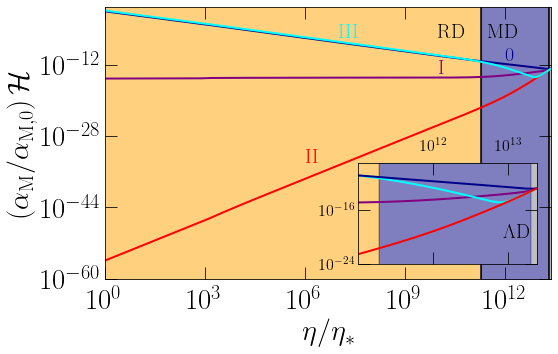

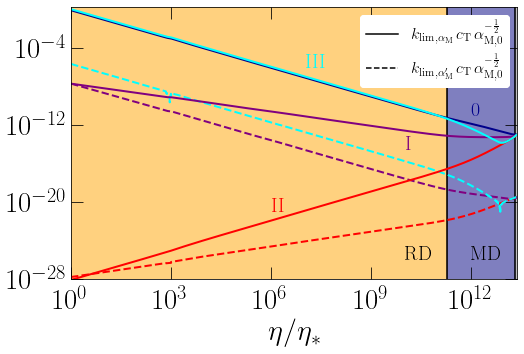

In [6]:
print(gen.plot_parameterizations_alpM.__doc__)

gen.plot_parameterizations_alpM(eta_n, a, Omega, Omega_mat, HH_n, eta_n_EQ, eta_n_acc, eta_n_0, OmM0,
                                comp_exp=1, nn_exp=1, save=True, figg=1,
                                primes=False, n2=False, n04=False, n1=True)

gen.plot_parameterizations_alpM(eta_n, a, Omega, Omega_mat, HH_n, eta_n_EQ, eta_n_acc, eta_n_0, OmM0,
                                comp_exp=1, nn_exp=1, save=True, figg=2,
                                primes=False, n2=False, n04=False, n1=True)


    Function that plots the spectra obtained using the WKB approximation
    in modified gravity for an initial GW background following a smoothed
    double broken power law.
    
    It generates the plots corresponding to figure 2 of
    Y. He, A. Roper Pol, and A. Brandenburg, "Modified propagation of
    gravitational waves from the early radiation era," submitted to JCAP
    (2022).
    
    Figures saved in 'plots/spectrum_WKB_late_times.pdf', 'plots/spectrum_WKB_normalized.pdf'
    


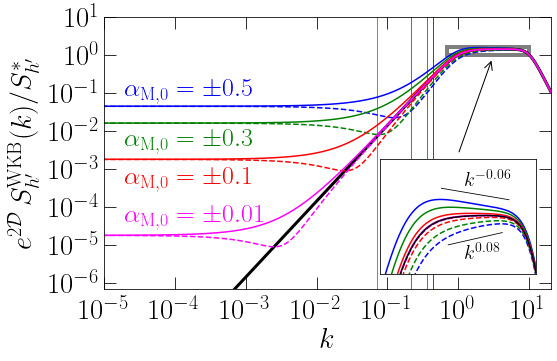

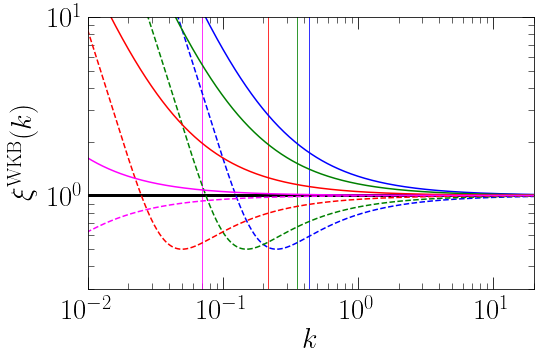

In [7]:
#### Spectra computed at late times from the WKB approximation
print(gen.plot_late_time_WKB.__doc__)
gen.plot_late_time_WKB(save=True)

In [7]:
#### compute the functions D = .5 \int \alpM HH d \eta for
#### the different choices of \alpM parameterizations

# set rd to False the first time to compute and save the variables
# if the file WKB/DDs.pkl does not exist or is not correct.
# Once this is done, one can set rd = True for faster evaluation
# (by reading the results stored in the file)

print(gen.time_evolution_WKB.__doc__)
rd = False

gS = co.thermal_g(T=T, s=1)
ast = co.as_a0_rat(T=T, g=gS)

DDs_0, DDs_I, DDs_I_n04, DDs_I_n2, DDs_II, DDs_III = \
        gen.time_evolution_WKB(eta_nn, HH_nn, a_nn, ast, Omega_nn,
                               OmM0, Omega_mat_nn, read=rd, save=True)


    Function that computes the D = .5 int alpM HH d eta integral
    for the different choices of alphaM parameterization that appears
    in the WKB approximation for the increase in GW energy density.
    
    Reference: Y. He, A. Roper Pol, A. Brandenburg, "Modified propagation of
    gravitational waves from the early radiation era," submitted to JCAP (2022).
    
    If read is False, it computes D and stores it as a pickle variable in
    'WKB/DDs.pkl', otherwise it directly reads it.
    



    Function that plots the time evolution of the GW energy density from
    the numerical simulations and using the WKB approximation in modified
    gravity.
    
    It generates the plots corresponding to figure 3 of
    Y. He, A. Roper Pol, and A. Brandenburg, "Modified propagation of
    gravitational waves from the early radiation era," submitted to JCAP (2022).
    
    Figures saved in 'plots/time_series_EEGW_choice'#'.pdf'
    
Saving figure plots/time_series_EEGW_choice0.pdf
Saving figure plots/time_series_EEGW_choiceI.pdf
Saving figure plots/time_series_EEGW_choiceII.pdf
Saving figure plots/time_series_EEGW_choiceIII.pdf


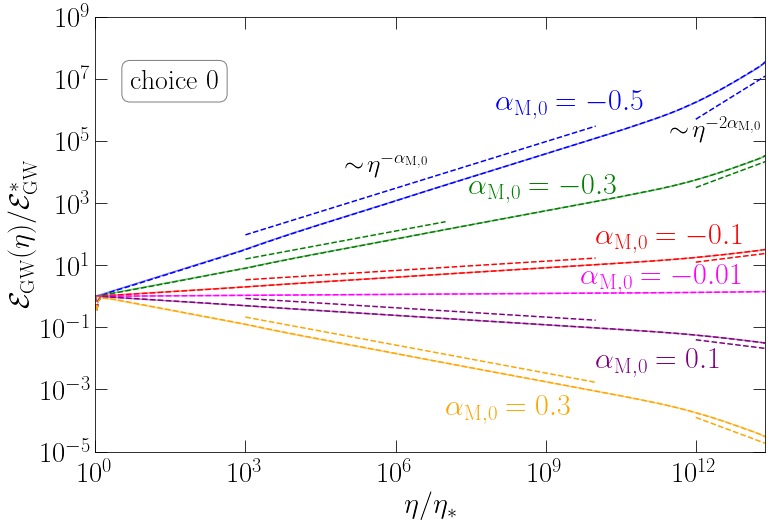

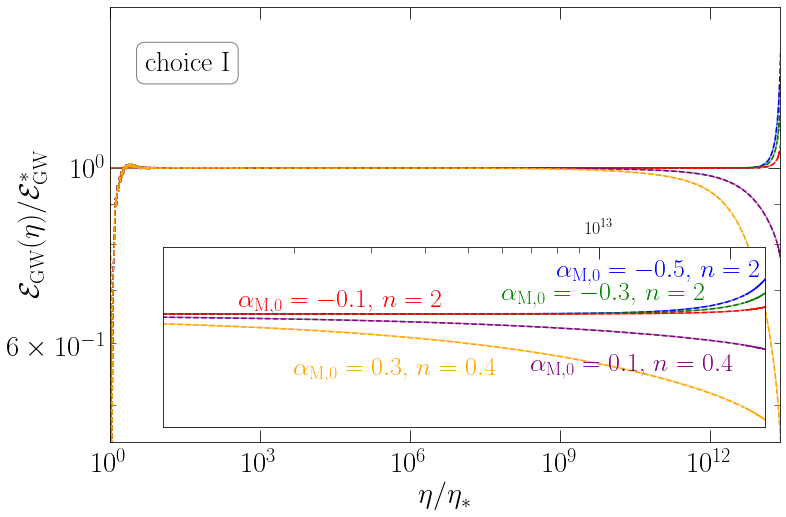

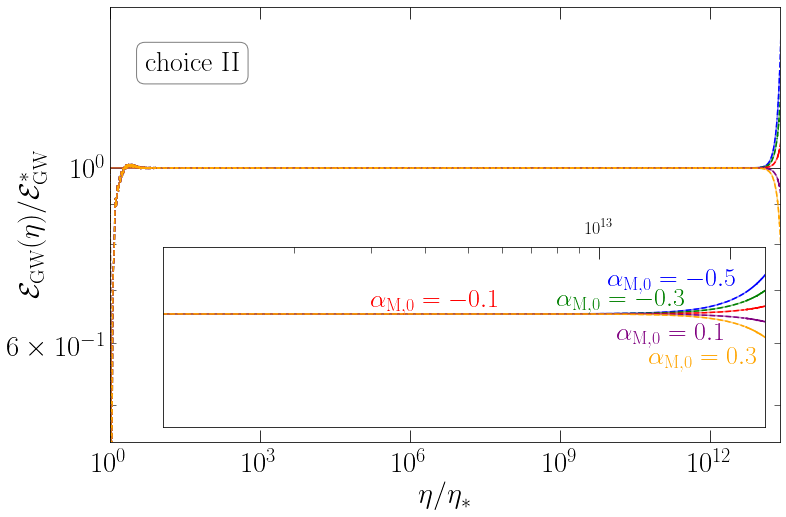

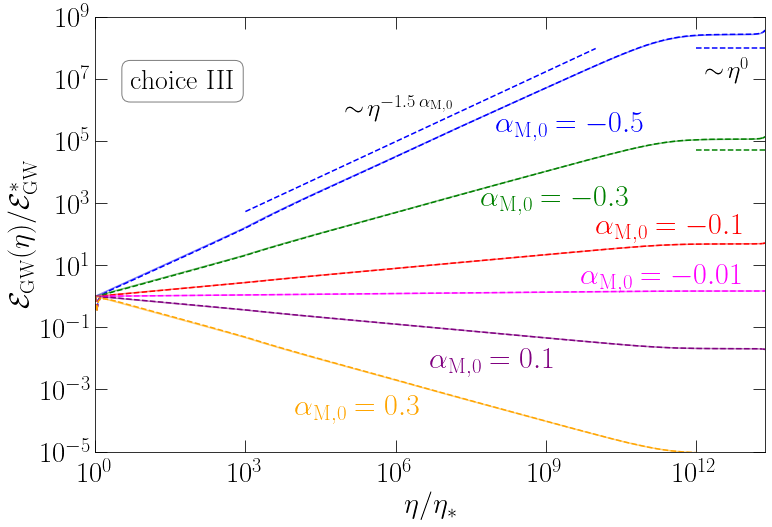

In [8]:
### plot time series of the GW energy density for the different choices
### once it has been run once and the results are saved, one can execute the
### function without reading the results from the run by setting rd = True
### the first time one needs to read the runs and set rd = False

print(gen.plot_time_evolution_EGW.__doc__)

# to compute these results, one needs to read the numerical results from
# the Pencil Code by first downloading the numerical datasets (see above)
# once this has been done, the files ts_#run.pkl can directly be read by setting
# rd to True
rd = False

if rd:
    runs_M0 = 0
    runs_M1 = 0
    runs_M2 = 0
    runs_M3 = 0

gen.plot_time_evolution_EGW(DDs_0, eta_nn, value0=False, choice='0', quiet=True,
                            runs=runs_M0, txt=True, save=True, save_pl=True, plot=True, read=rd)
gen.plot_time_evolution_EGW(DDs_I_n2, eta_nn, value0=False, choice='I', quiet=True,
                            runs=runs_M1, DDs2=DDs_I_n04, txt=True, save=True, save_pl=True,
                            plot=True, read=rd)
gen.plot_time_evolution_EGW(DDs_II, eta_nn, value0=False, choice='II', quiet=True, runs=runs_M2,
                            txt=True, save=True, save_pl=True, plot=True, read=rd)
gen.plot_time_evolution_EGW(DDs_III, eta_nn, value0=False, choice='III', quiet=True, runs=runs_M3,
                            txt=True, save=True, save_pl=True, plot=True, read=rd)


    Function that plots the error of the time evolution of the GW energy
    density computed using the WKB approximation in modified gravity,
    compared to the results from numerical simulations.
    
    It generates the plots corresponding to figure 4 of
    Y. He, A. Roper Pol, and A. Brandenburg, "Modified propagation of
    gravitational waves from the early radiation era,"
    submitted to JCAP (2022).
    
    It requires to first generate the results for the time series
    using plot_time_evolution_EGW
    
    Figures saved in 'plots/time_series_alpM_choice#_error_WKB.pdf'
    
Saving figure plots/time_series_alpM_choice0_error_WKB.pdf
Saving figure plots/time_series_alpM_choiceI_error_WKB.pdf
Saving figure plots/time_series_alpM_choiceII_error_WKB.pdf
Saving figure plots/time_series_alpM_choiceIII_error_WKB.pdf


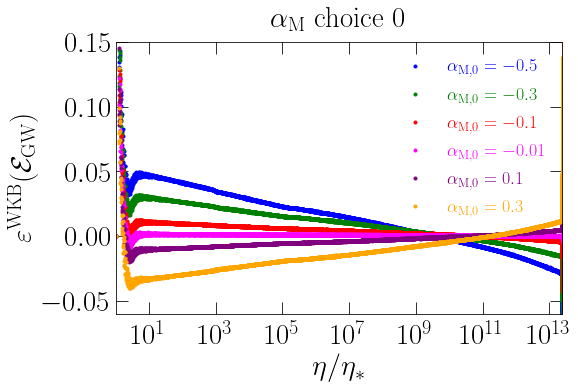

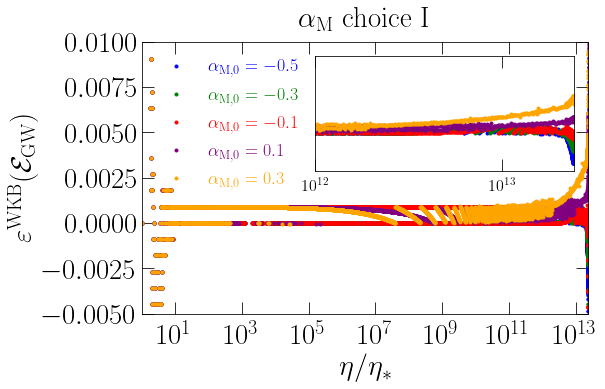

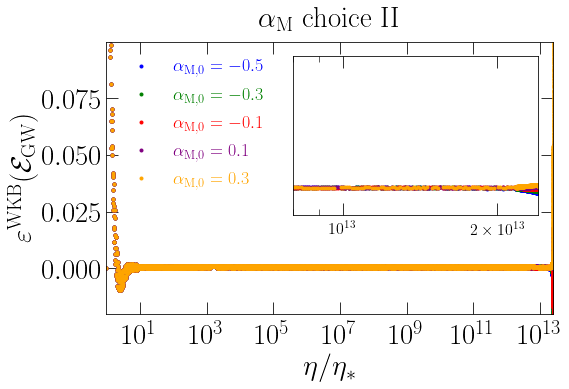

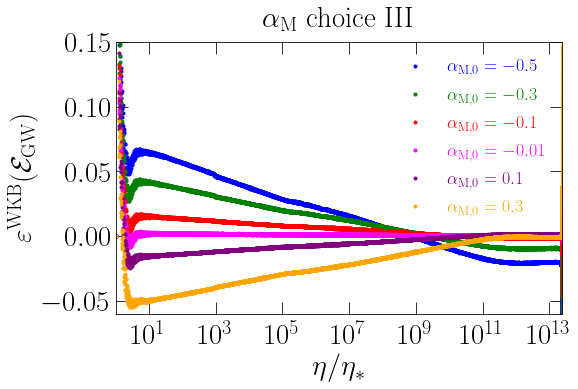

In [9]:
### plot time series of the WKB error in the GW energy density
### for the different choices

print(gen.plot_time_series_error_WKB.__doc__)

gen.plot_time_series_error_WKB(DDs_0, eta_nn, choice='0')
gen.plot_time_series_error_WKB(DDs_I_n2, eta_nn, DDs2=DDs_I_n04, choice='I')
gen.plot_time_series_error_WKB(DDs_II, eta_nn, choice='II')
gen.plot_time_series_error_WKB(DDs_III, eta_nn, choice='III')

In [11]:
##### compute spectra (average, envelope) by combining the 4 different
##### runs and save the results as a pickle variable, it can be just loaded
##### after running once by setting rd = True

# to compute these results, one needs to read the numerical results from
# the Pencil Code by first downloading the numerical datasets (see above)
# once this has been done, the files pos_alpM_sp_ch#.pkl and neg_alpM_sp_ch#.pkl
# can directly be read by setting rd to True

print(gen.compute_all_spectra.__doc__)

## choice 0
rd = False
if rd:
    runs_M0 = 0
    runs_M0_lowk = 0
    runs_M1 = 0
    runs_M2 = 0
    runs_M3 = 0
    runs_M3_lowk = 0

neg_alpM_sp_ch0, pos_alpM_sp_ch0 = \
        gen.compute_all_spectra(eta_nn, HH_nn, a_nn, Omega_nn, Omega_mat_nn, OmM0, DDs_0,
                                ch='0', save=True, read=rd, runs=runs_M0, runs_lowk=runs_M0_lowk)
## choice III
neg_alpM_sp_chIII, pos_alpM_sp_chIII = \
        gen.compute_all_spectra(eta_nn, HH_nn, a_nn, Omega_nn, Omega_mat_nn, OmM0, DDs_III,
                                ch='III', save=True, read=rd, runs=runs_M3, runs_lowk=runs_M3_lowk)

## choice I
neg_alpM_sp_chI, pos_alpM_sp_chI = \
        gen.compute_all_spectra(eta_nn, HH_nn, a_nn, Omega_nn, Omega_mat_nn, OmM0, DDs_I_n2,
                                DDs2=DDs_I_n04, ch='I', save=True, read=rd, runs=runs_M1)

## choice II
neg_alpM_sp_chII, pos_alpM_sp_chII = \
        gen.compute_all_spectra(eta_nn, HH_nn, a_nn, Omega_nn, Omega_mat_nn, OmM0, DDs_II,
                                ch='II', save=True, read=rd, runs=runs_M2)


    Function that computes all spectra for a specific choice of alpM parameterization:
        '0', 'I', 'II' or 'III'
    It returns the results for the different values of alpM0: 'A' to 'F' (choices 0 or III)
    or 'A' to 'E' (choices I and II).
    It returns separately the results for positive and negative values of alpM
    
    If save = True and read = False, then it computes the spectra and saves the results in
            'results/pos_alpM_sp_ch#ch.pkl'
    
    If read = True, then it reads the already computed results.
    
Saving results in pickle variable results/neg_alpM_sp_ch0.pkl
Saving results in pickle variable results/pos_alpM_sp_ch0.pkl
Saving results in pickle variable results/neg_alpM_sp_chIII.pkl
Saving results in pickle variable results/pos_alpM_sp_chIII.pkl
Saving results in pickle variable results/neg_alpM_sp_chI.pkl
Saving results in pickle variable results/pos_alpM_sp_chI.pkl
Saving results in pickle variable results/neg_alpM_sp_chII.pkl
Saving results in 


    Function that computes the spectra combining the 4 runs for all cases A to D
    for choices 0 and III (negative values of alpha_M)
    It uses the numerical spectra to obtain the envelope over oscillations
    at each wave number and compensates by the total growth in the GW
    energy density obtained (and verified) from the WKB approximation.
    It also returns the WKB estimated spectra at late times.
    
    It generates the plots corresponding to figure 5 of
    Y. He, A. Roper Pol, and A. Brandenburg, "Modified propagation of
    gravitational waves from the early radiation era,"
    submitted to JCAP (2022).
    Negative values of alpM (left panel) if neg is True and positive
    values (right panel) if neg is False.
    
    Figure saved in 'plots/spectra_envelope_choices_0_III.pdf'
    
Saving figure in plots/spectra_envelope_choices_0_III.pdf
Saving figure in plots/spectra_envelope_choices_0_III_posaM.pdf


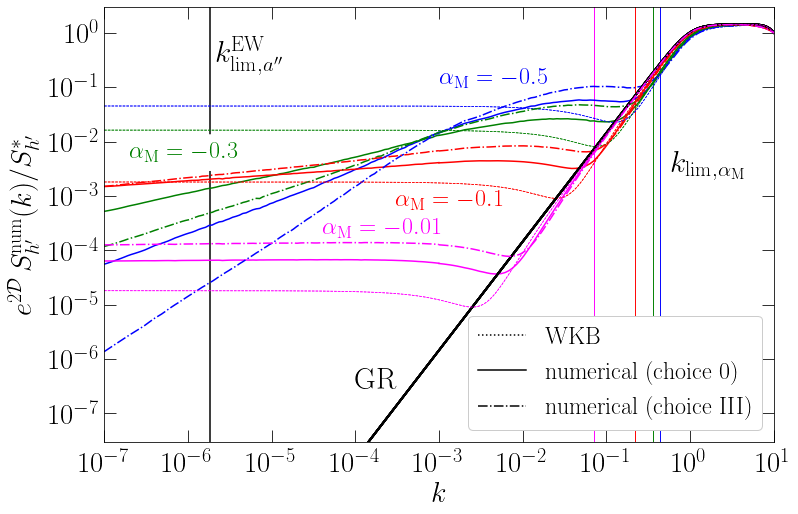

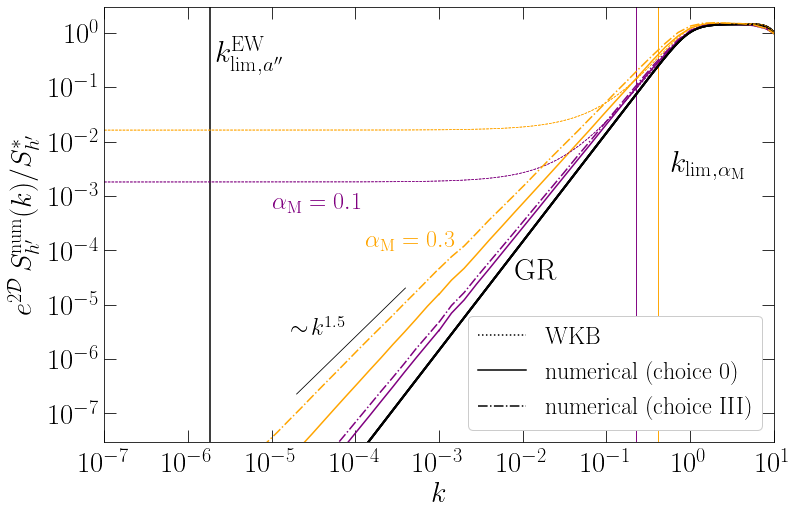

In [13]:
## The value of fact = 3.5e-10 corresponds to the amplitude A of the
## numerical runs when fitted to the double power law.
## It has to be computed separately while reading the runs

print(gen.plot_all_spectra.__doc__)

# negative values of alpM
gen.plot_all_spectra(neg_alpM_sp_ch0, neg=True, app=app_nn[0], ch='0', save=False,
                     newf=True, lss='solid', txt=True, fact=3.5e-10)
gen.plot_all_spectra(neg_alpM_sp_chIII, neg=True, app=app_nn[0], ch='III', save=True,
                     newf=False, lss='-.', txt=True, fact=3.5e-10)

# positive values of alpM
gen.plot_all_spectra(pos_alpM_sp_ch0, neg=False, app=app_nn[0], ch='0', save=False,
                     newf=True, lss='solid', txt=True, fact=3.5e-10)
gen.plot_all_spectra(pos_alpM_sp_chIII, neg=False, app=app_nn[0], ch='III', save=True,
                     newf=False, lss='-.', txt=True, fact=3.5e-10)


    Function that computes the spectra combining the 4 runs for all cases A to F
    for choices 0 and III.
    It uses the numerical spectra to obtain the envelope over oscillations
    at each wave number and compensates by the total growth in the GW
    energy density obtained (and verified) from the WKB approximation.
    It also returns the WKB estimated spectra at late times.
    
    It generates the plots corresponding to figure 6 of
    Y. He, A. Roper Pol, and A. Brandenburg, "Modified propagation of
    gravitational waves from the early radiation era," submitted to JCAP (2022).
    
    Figure saved in 'plots/spectra_envelope_choices_0_III_norm.pdf'
    
Saving figure in plots/spectra_envelope_choices_0_III_norm.pdf


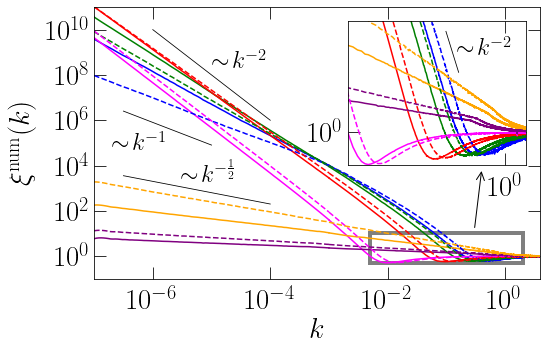

In [14]:
print((gen.plot_all_spectra_norm.__doc__))
      
ax, iax = gen.plot_all_spectra_norm(pos_alpM_sp_ch0, neg_alpM_sp_ch0, ch='0', save=False,
                          newf=True, txt=True)

gen.plot_all_spectra_norm(pos_alpM_sp_chIII, neg_alpM_sp_chIII, ch='III', save=True,
                          newf=False, ax=ax, iax=iax, lss='dashed')


    Function that plots the slopes of the spectra after averaging over
    oscillations (by using the envelope).
    
    It generates the plots corresponding to figure 6 of
    Y. He, A. Roper Pol, and A. Brandenburg, "Modified propagation of
    gravitational waves from the early radiation era," submitted to JCAP (2022).
    
    Figure saved in 'plots/slopes_choices0_III.pdf'
    
Saving figure in plots/slopes_choices0_III.pdf


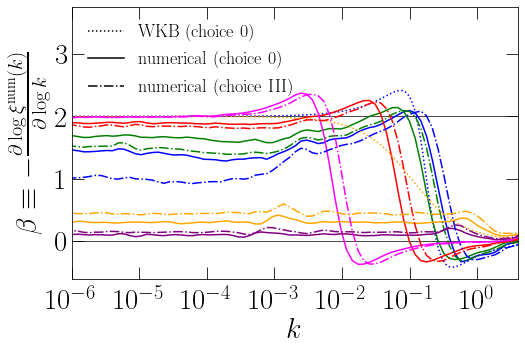

In [15]:
print(gen.plot_spectra_slopes.__doc__)
gen.plot_spectra_slopes(pos_alpM_sp_ch0, neg_alpM_sp_ch0, ch='0', txt=True, newf=True, save=False,
                        lss='solid', kdisc=100)
gen.plot_spectra_slopes(pos_alpM_sp_chIII, neg_alpM_sp_chIII, ch='III', txt=True, newf=False,
                        lss='-.', kdisc=100, save=True)


    Function that computes the error in the spectrum from the WKB estimate
    compared with the resulting averaged saturated spectra obtained from
    the numerical simulations for choices 0 and III.
    
    It generates the plots corresponding to figure 7 of
    Y. He, A. Roper Pol, and A. Brandenburg, "Modified propagation of
    gravitational waves from the early radiation era," submitted to JCAP (2022).
    
    Figure saved in 'plots/spectra_envelope_error_WKB_choice#ch.pdf'
    
    Arguments:
        spectrapos -- dictionary with numerical spectra for positive values
                      of alpha_M
        spectraneg -- id for negative values of alpha_M
        ch -- choice of alpha_M parameterization
        err_fill -- option to fill between -15 to 15% error
    


/Users/roperpol/GW_turbulence/GW_turbulence/horndeski/generate_horndeski.py:1432: RuntimeWarning: divide by zero encountered in true_divide
  err_relAc = 2*((WKBAAc[1:] - .5*envcA[1:])/envcA[1:])
/Users/roperpol/GW_turbulence/GW_turbulence/horndeski/generate_horndeski.py:1432: RuntimeWarning: divide by zero encountered in true_divide
  err_relAc = 2*((WKBAAc[1:] - .5*envcA[1:])/envcA[1:])


Saving figure in plots/spectra_envelope_error_WKB_choice0.pdf


/Users/roperpol/GW_turbulence/GW_turbulence/horndeski/generate_horndeski.py:1432: RuntimeWarning: divide by zero encountered in true_divide
  err_relAc = 2*((WKBAAc[1:] - .5*envcA[1:])/envcA[1:])
/Users/roperpol/GW_turbulence/GW_turbulence/horndeski/generate_horndeski.py:1432: RuntimeWarning: divide by zero encountered in true_divide
  err_relAc = 2*((WKBAAc[1:] - .5*envcA[1:])/envcA[1:])


Saving figure in plots/spectra_envelope_error_WKB_choiceIII.pdf


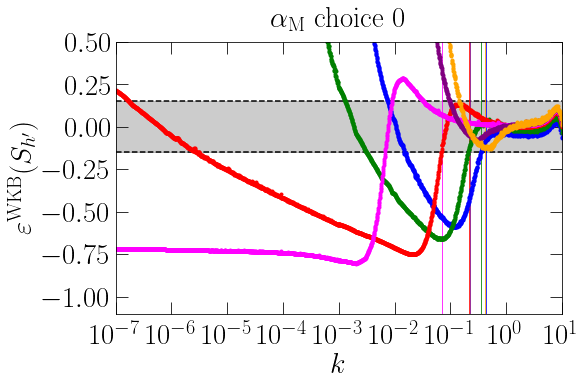

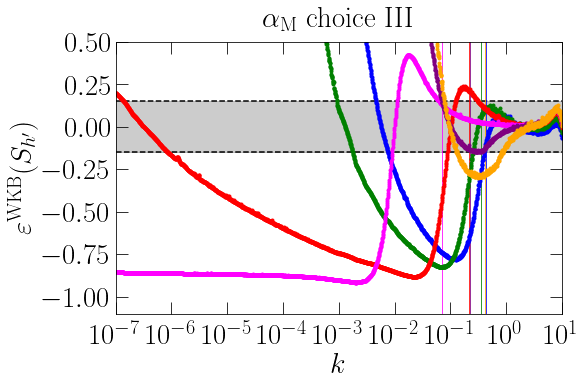

In [16]:
print(gen.plot_spectra_error_WKB.__doc__)
gen.plot_spectra_error_WKB(pos_alpM_sp_ch0, neg_alpM_sp_ch0, ch='0', err_fill=True, save=True)
gen.plot_spectra_error_WKB(pos_alpM_sp_chIII, neg_alpM_sp_chIII, ch='III', err_fill=True, save=True)


    Function that generates the plot of the present-time GW spectra obtained for different
    values of alpM0 for a given choice of alphaM parameterization (choice 0 or III are
    available).
    
    It plots the spectra from the numerical simulations assuming the signal has been
    generated at a specific epoch within RD, determined by T and g.
    
    It generates the plots corresponding to figure 8 of
    Y. He, A. Roper Pol, and A. Brandenburg, "Modified propagation of
    gravitational waves from the early radiation era," submitted to JCAP (2022).
    
    Figures saved in 'plots/OmGW_detectorsEWPT.pdf' and 'plots/OmGW_detectorsQCDT.pdf'
    
    Arguments:
    
        spectrapos -- 
        spectraneg -- 
        DDs -- array of damping factor as a function of time for different values of alpM
        ch -- choice of alpM parameterization (default 0)
        EEGW_st -- integrated GW energy density normalized by the radiation energy density
                    (default is 1

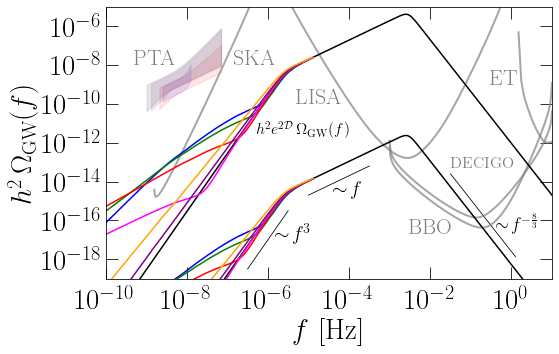

In [17]:
print(gen.plot_OmegaGW_mod_today.__doc__)
ax, iax = gen.plot_OmegaGW_mod_today(pos_alpM_sp_chIII, neg_alpM_sp_chIII, DDs_III, ch='III',
                           EEGW_st=2.5e-7, newf=True, dets=True, kGWp=600*1.6,
                           T=100*u.GeV, g=100, kc=5, kdisc=1000,
                           fact=3.5e-10, epoch='EWPT', txt=True, save=False)

gen.plot_OmegaGW_mod_today(pos_alpM_sp_chIII, neg_alpM_sp_chIII, DDs_III, ch='III',
                           EEGW_st=4.4e-1, newf=False, kGWp=600*1.6,
                           T=100*u.GeV, g=100, kc=5, kdisc=1000, ax=ax, iax=iax,
                           fact=3.5e-10, epoch='EWPT', txt=True, save=True)

Saving figure in plots/OmGW_detectorsQCDPT.pdf


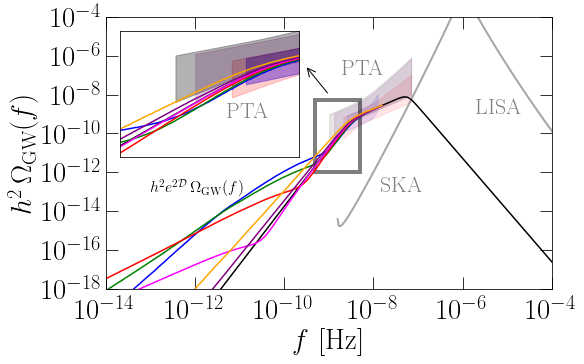

In [18]:
TQCD = 150*u.MeV
gQCD = co.thermal_g(T=TQCD, s=0)

_ = gen.plot_OmegaGW_mod_today(pos_alpM_sp_chIII, neg_alpM_sp_chIII, DDs_III, ch='III',
                               EEGW_st=5e-4, newf=True, dets=True, kGWp=10*1.6,
                               T=TQCD, g=gQCD, kc=5, kdisc=1000,
                               fact=3.5e-10, epoch='QCDPT', txt=True, save=True)

In [19]:
### compute amplification/damping factors for EWPT and QCDPT
T_EWPT = 100*u.GeV
Q = ho.compute_Qs(a, eta, ap_a, app_a, T=T, OmM0=OmM0, h0=h0)
T_QCD = 150*u.MeV
Q_QCD = ho.compute_Qs(a, eta, ap_a, app_a, T=T_QCD, OmM0=OmM0, h0=h0)

### range of alpM0s
alpsM0 = -np.logspace(np.log10(.5), -5, 1000)
alpsM0 = np.append(alpsM0, np.logspace(-5, np.log10(.5), 1000))


    Function that plots the amplification (damping) for the 4 different choices
    of alpM parameterization from the time of generation until present time
    given the temperature scale within the RD at which the signal was generated.
    
    It considers the EWPT and the QCDPT as the initial times of generation.
    
    It generates the plots corresponding to figure 9 of
    Y. He, A. Roper Pol, and A. Brandenburg, "Modified propagation of
    gravitational waves from the early radiation era," submitted to JCAP (2022).
    
    Figures saved in 'plots/OmGW_detectorsEWPT.pdf' and 'plots/OmGW_amplification.pdf'
    
    Arguments:
        Q -- array of reference amplifications for alpM0 for the 4 choices
             produced at the EWPT
        Q_QCD -- array of reference amplifications for alpM0 for the 4 choices
                 produced at the QCDPT
        alpsM0 -- array of values of alpM at present time
        
    
Saving figure in plots/OmGW_amplification.pdf


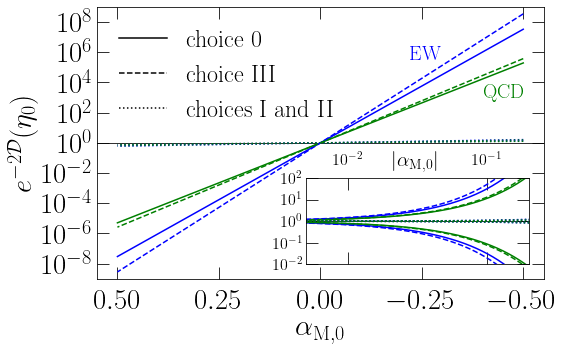

In [20]:
print(gen.plot_amplification_damping.__doc__)
gen.plot_amplification_damping(Q, Q_QCD, alpsM0, txt=True, save=True)